In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy
import skimage.io as skimage

from collections import defaultdict
from glob import glob
from random import shuffle
from scipy import signal
from scipy.ndimage import measurements

In [8]:
'''
takes a list of lab names, iterates through file names, and puts file names into a 
dictionary cooresponding to lab name with in file
'''
def spilt_files(lab_names, files):
    lab_names_to_files = defaultdict(list)
    
    for file in files:
        lab_name_found = False
        for lab_name in lab_names:
            if re.search(lab_name, file):
                lab_names_to_files[lab_name].append(file)
                lab_name_found = True
        if not lab_name_found:
            print('error file name: ' + file + ' not found in lab names')
            
    return lab_names_to_files

In [3]:
INITIAL_DATA_GLOB = glob('/Users/sabera.talukder/Desktop/anithaTestData/*.tiff')
files = sorted(INITIAL_DATA_GLOB)

In [15]:
NUM_P200_FILES = 8000
NUM_P300_FILES = 2250
lab_names = ['_p200', '_p300']

# split data files based on lab name
lab_names_to_files = spilt_files(lab_names, files)

assert len(lab_names_to_files['_p200']) == NUM_P200_FILES, 'missing files'
assert len(lab_names_to_files['_p300']) == NUM_P300_FILES, 'missing files'

files_200 = np.array(lab_names_to_files['_p200'])
files_300 = np.array(lab_names_to_files['_p300'])

In [19]:
def convert_file_names_to_img_arr(file_name_list):
    return np.array([skimage.imread(f) for f in file_name_list])

In [20]:
imgs2 = convert_file_names_to_img_arr(files_200)

In [26]:
imgs3 = convert_file_names_to_img_arr(files_300)

STOPPED EDITING WITH MIHAIL HERE

In [5]:
dims2 = imgs2.shape[1:]
dims3 = imgs3.shape[1:]

In [6]:
def to_mask(coords, dims):
    mask = np.zeros(dims)
    tst = zip(*coords)
    for idx, item in enumerate(tst):
        if idx == 0:
            row = item
        else:
            col = item
    mask[row, col] = 1
    return mask

In [8]:
with open('neurofinder.02.00/regions/regions.json') as f:
    regions2 = json.load(f)
    
with open('neurofinder.03.00/regions/regions.json') as f:
    regions3 = json.load(f)

mask2 = np.array([(print, to_mask(s['coordinates'], dims2)) for idx, s in enumerate(regions2)])
shortMask2 = mask2[:, 1]

mask3 = np.array([(print, to_mask(s['coordinates'], dims3)) for idx, s in enumerate(regions3)])
shortMask3 = mask3[:, 1]

<font size = '+2'>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
That was loading all of the data that we need and visualizing it. Now we will look at creating the masks for each layer of the original image.
    <p>   </p>
    <p>   </p>
I'm going to work with just mask 3 for now.
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
</font>

In [100]:
# get the total areas for all of the masks

areas = []
# comes in the form of the (1) mask idx, (2) the area, (3) xMax, (4) xMin, (5) yMax, (6) yMin
maskInfo = []
idx = 0

for mask in shortMask3:
    unique, counts = np.unique(mask, return_counts=True)

    test = np.where(mask == 1)
    
    xMax = np.max(test[0])
    xMin = np.min(test[0])
    yMax = np.max(test[1])
    yMin = np.min(test[1])
    
    maskInfo.append([idx, counts[-1], xMax, xMin, yMax, yMin])
    idx = idx + 1


In [107]:
maskInfo[0]

[0, 155, 23, 9, 108, 96]

In [111]:
maskInfo[0][-1]

96

In [10]:
# normalize the true image values to be 0-255

imgs3Corrected = np.zeros([imgs3.shape[0],imgs3.shape[1],imgs3.shape[2]])
idx = 0
for img in imgs3:
    imgs3Corrected[idx,:,:] = imgs3[idx,:,:]/ np.max(imgs3[idx,:,:]) * 255
    idx = idx + 1

In [113]:
imgs3Corrected.shape

(2250, 498, 490)

In [114]:
len(maskInfo)

621

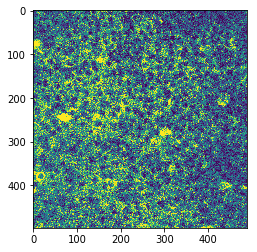

In [127]:
plt.imshow(imgs3Corrected[0])

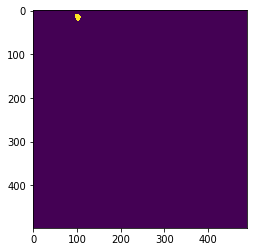

In [130]:
plt.imshow(shortMask3[0])

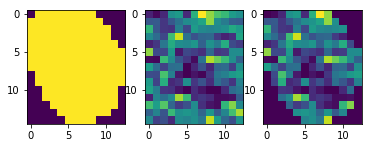

Press Enter to continue...


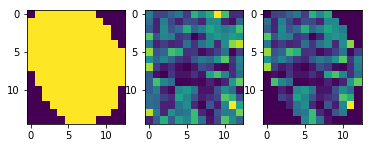

Press Enter to continue...


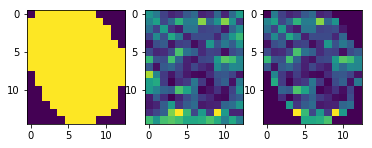

Press Enter to continue...


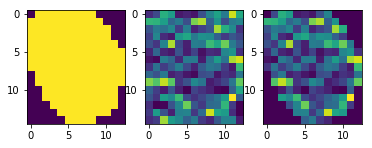

Press Enter to continue...


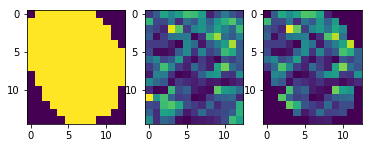

KeyboardInterrupt: 

In [124]:
# this for loop goes 621 by 2250
arrayIdx = 0
for array in maskInfo:
    imgIdx = 0
    mask = shortMask3[imgIdx][maskInfo[arrayIdx][3]:maskInfo[arrayIdx][2]+1, maskInfo[arrayIdx][-1]:maskInfo[arrayIdx][-2]+1]
    for img in imgs3Corrected:
        original = img[maskInfo[arrayIdx][3]:maskInfo[arrayIdx][2]+1, maskInfo[arrayIdx][-1]:maskInfo[arrayIdx][-2]+1]
        neuron = mask * original
        
        plt.subplot(1,3,1)
        plt.imshow(mask)
        plt.subplot(1,3,2)
        plt.imshow(original)
        plt.subplot(1,3,3)
        plt.imshow(neuron)
        plt.show()
        imgIdx = imgIdx + 1;
        input("Press Enter to continue...")
#         median = np.median(temp)
#         maskMedian[maskIdx,timeIdx] = median
    arrayIdx += 1
        

In [122]:
print(arrayIdx)

0


In [14]:
# TODO: how exactly should we calculate the value allocated to the activation array?
# medians or adjusted averages?
# they must be comparable to all of the other masks that do not necessarily have the same shape

In [11]:
# This does it with medians

maskIdx = 0
# is 621 neurons by 2250 time points in the series
maskMedian = np.zeros([shortMask3.shape[0],imgs3Corrected.shape[0]])

for mask in shortMask3:
    timeIdx = 0
    test = np.where(shortMask3[maskIdx] == 1)
    xMax = np.max(test[0])
    xMin = np.min(test[0])
    yMax = np.max(test[1])
    yMin = np.min(test[1])
    neuron = shortMask3[maskIdx][xMin:xMax+1, yMin:yMax+1]
    
    for img in imgs3Corrected:
        temp = img[xMin:xMax+1, yMin:yMax+1] * neuron
        median = np.median(temp)
        maskMedian[maskIdx,timeIdx] = median
        timeIdx = timeIdx + 1;
        
    maskIdx = maskIdx + 1

In [15]:
# This does it with averages

maskIdx = 0
# is 621 neurons by 2250 time points in the series
maskAverage = np.zeros([shortMask3.shape[0],imgs3Corrected.shape[0]])

for mask in shortMask3:
    timeIdx = 0
    test = np.where(shortMask3[maskIdx] == 1)
    xMax = np.max(test[0])
    xMin = np.min(test[0])
    yMax = np.max(test[1])
    yMin = np.min(test[1])
    neuron = shortMask3[maskIdx][xMin:xMax+1, yMin:yMax+1]
    
    for img in imgs3Corrected:
        temp = img[xMin:xMax+1, yMin:yMax+1] * neuron
        mean = np.mean(temp)
        maskAverage[maskIdx,timeIdx] = mean
        timeIdx = timeIdx + 1;
        
    maskIdx = maskIdx + 1

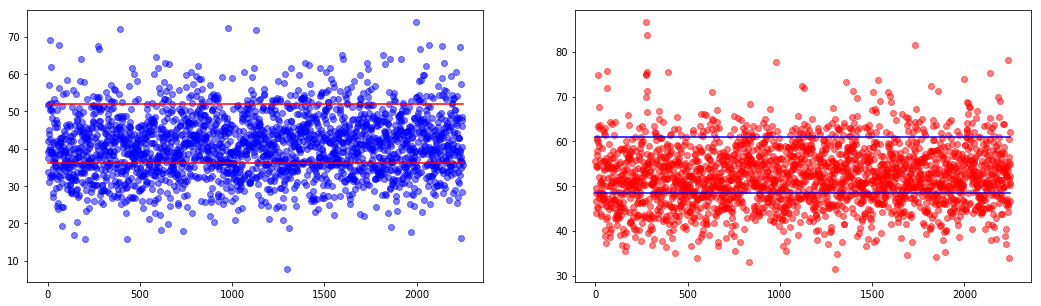

In [26]:
neuronNum = 500
topPercent = 90
botPercent = 30

xAxis = np.linspace(0,maskMedian.shape[1],maskMedian.shape[1])

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.scatter(xAxis,maskMedian[neuronNum,:], color='blue',alpha=.5)
plt.plot([0, 2250], [np.percentile(maskMedian[neuronNum,:],topPercent), np.percentile(maskMedian[neuronNum,:],topPercent)], color='red')
plt.plot([0, 2250], [np.percentile(maskMedian[neuronNum,:],botPercent), np.percentile(maskMedian[neuronNum,:],botPercent)], color='red')

plt.subplot(1,2,2)
plt.scatter(xAxis,maskAverage[neuronNum,:], color='red',alpha=.5)
plt.plot([0, 2250], [np.percentile(maskAverage[neuronNum,:],topPercent), np.percentile(maskAverage[neuronNum,:],topPercent)], color='blue')
plt.plot([0, 2250], [np.percentile(maskAverage[neuronNum,:],botPercent), np.percentile(maskAverage[neuronNum,:],botPercent)], color='blue')





In [74]:
maskAverage.shape[1]

2250

In [34]:
# How many neurons are above the 90th percent in the average and mean case?
medianIdxs = []
averageIdx = []

for idx in range(0,maskMedian.shape[1]):
     if maskMedian[neuronNum, idx] >= np.percentile(maskMedian[neuronNum,:],topPercent):
            medianIdxs.append(idx)
            
for idx in range(0,maskAverage.shape[1]):
     if maskAverage[neuronNum, idx] >= np.percentile(maskAverage[neuronNum,:],topPercent):
            averageIdx.append(idx)

In [39]:
medianIdxs = np.asarray([medianIdxs])
averageIdx = np.asarray([averageIdx])

In [71]:
difs = np.setdiff1d(medianIdxs, averageIdx)
same = np.intersect1d(medianIdxs, averageIdx)
# now that we know whether this timestamp came from the median or average math we can see which is a better metric
# by comparing where the mask aligns or not

# difs correspond to the idx within the time series of neuron #500

In [81]:
print(difs.shape)
print(same.shape)

(98,)
(128,)


In [56]:
allMasks = np.zeros([shortMask3[0].shape[0],shortMask3[0].shape[1]])
for mask in shortMask3:
    allMasks = allMasks + mask

In [58]:
maskMedian.shape

(621, 2250)

In [79]:
imgs3Corrected.shape

(2250, 498, 490)

In [80]:
plt.imshow(imgs3Corrected[same[2249],:,:] == 0)

IndexError: index 2249 is out of bounds for axis 0 with size 128

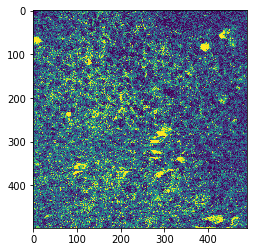

In [85]:
plt.imshow(imgs3Corrected[same[127],:,:])

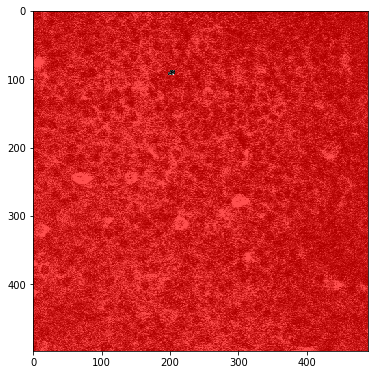

In [87]:
plt.figure(figsize=(6, 16))

plt.imshow(imgs3Corrected[difs[0],:,:], cmap = 'gray')
Img2 = np.ma.masked_array(shortMask3[difs[0]] == 0, shortMask3[difs[0]])
plt.imshow(Img2, cmap = 'hsv',alpha = .7)

plt.show()

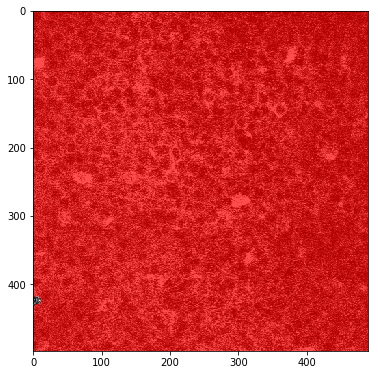

Press Enter to continue...


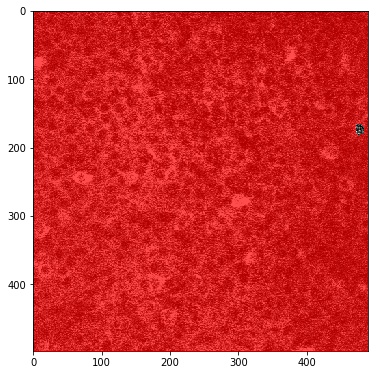

Press Enter to continue...


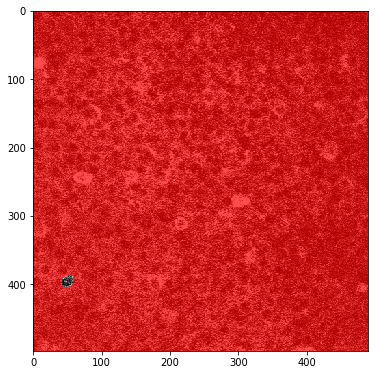

Press Enter to continue...


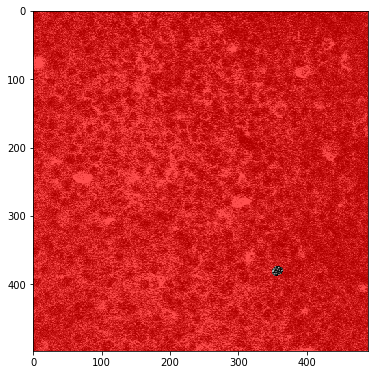

Press Enter to continue...


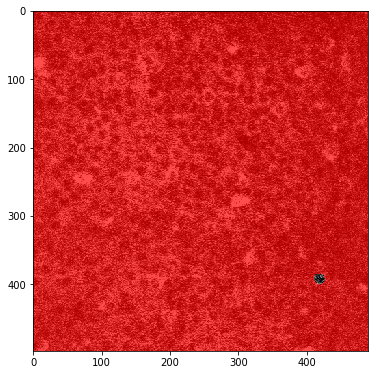

Press Enter to continue...


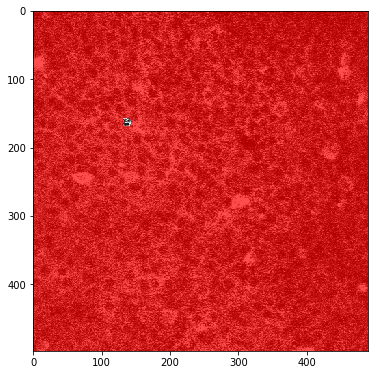

Press Enter to continue...


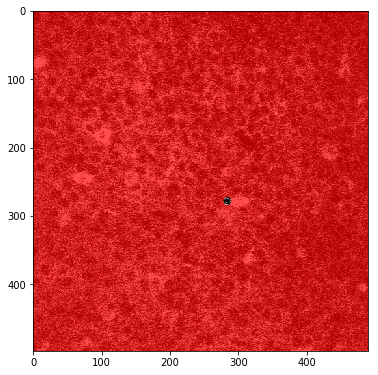

Press Enter to continue...


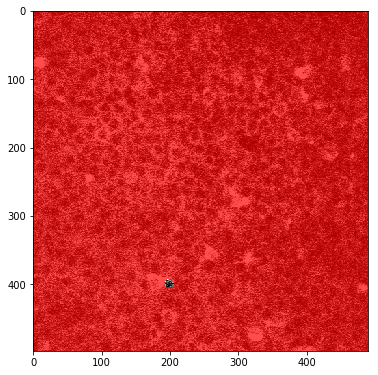

Press Enter to continue...


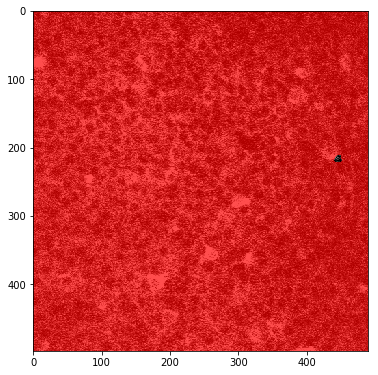

Press Enter to continue...


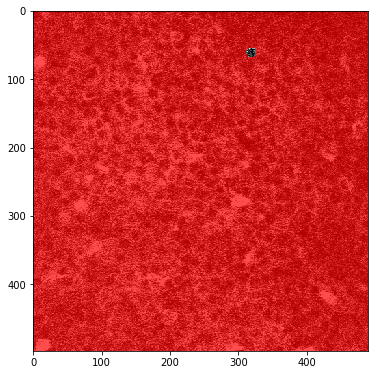

Press Enter to continue...


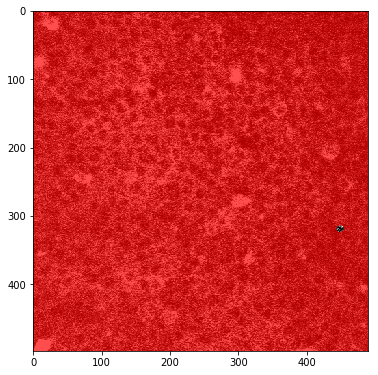

Press Enter to continue...


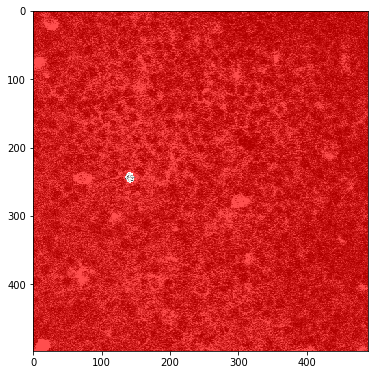

Press Enter to continue...


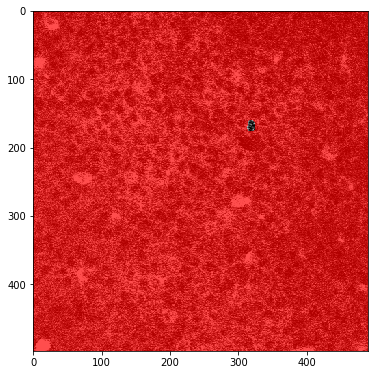

Press Enter to continue...


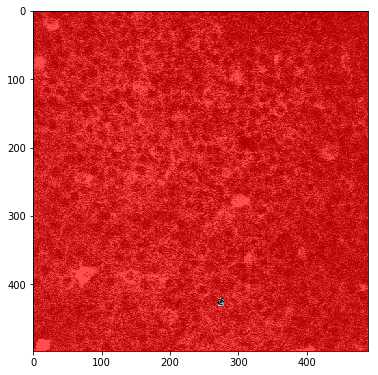

Press Enter to continue...


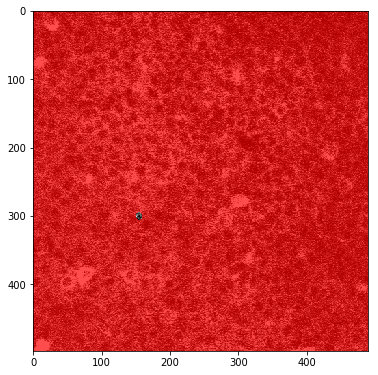

Press Enter to continue...


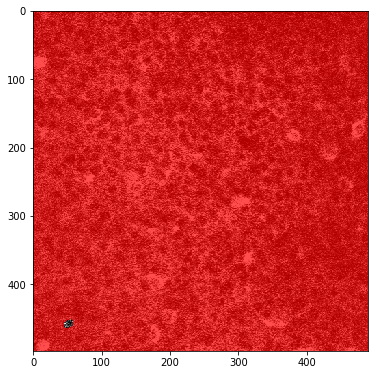

Press Enter to continue...


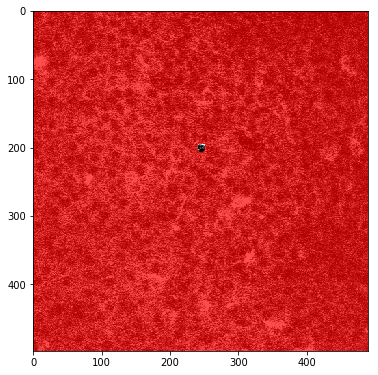

Press Enter to continue...


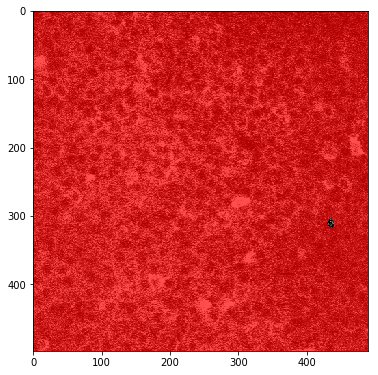

Press Enter to continue...


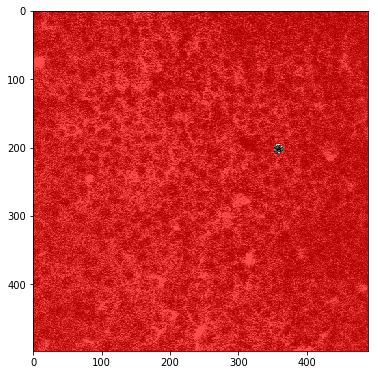

Press Enter to continue...


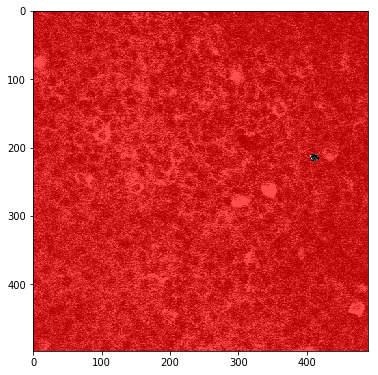

Press Enter to continue...


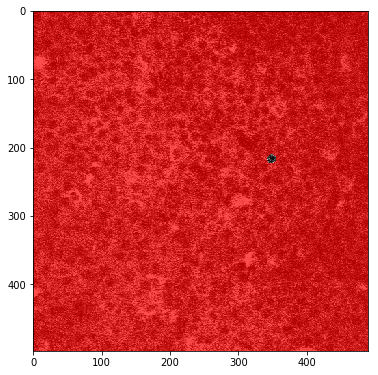

Press Enter to continue...


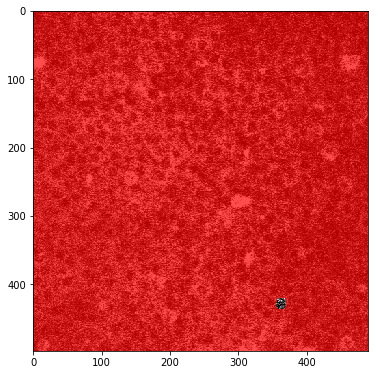

Press Enter to continue...


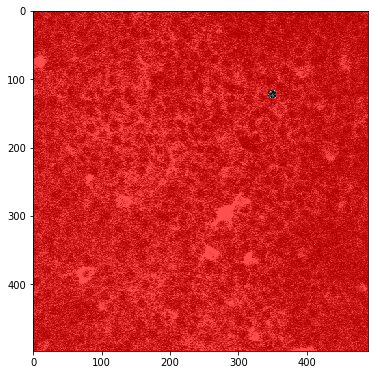

Press Enter to continue...


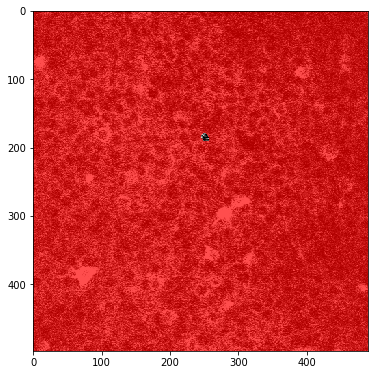

KeyboardInterrupt: 

In [98]:
for idxOfChoice in range(0,same.shape[0]):
    plt.figure(figsize=(6, 16))

    plt.imshow(imgs3Corrected[same[idxOfChoice],:,:], cmap = 'gray')
    Img2 = np.ma.masked_array(shortMask3[same[idxOfChoice]] == 0, shortMask3[same[idxOfChoice]])
    plt.imshow(Img2, cmap = 'hsv',alpha = .7)

    plt.show()
    input("Press Enter to continue...")